In [ ]:
%load_ext autoreload
%autoreload 2
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [1]:
import torch
import torchvision.models
from PIL import Image
import numpy as nps
import matplotlib.pyplot as plt
from lib.autoencoder import FeatureEncoder
#from lib.attention_model import AttentionLayer
from lib.correspondence_datamodule import CorrespondenceDataModule
from lib.warping import *
from externals.d2net.lib.utils import *

In [2]:
from pytorch_lightning import LightningDataModule

In [3]:
megadepth_path = "/home/witi/Projects/MegaDepthDataset"
data_module = CorrespondenceDataModule(base_path=megadepth_path, batch_size=1)
data_module.prepare_data()
data_module.setup(stage='fit')
dl_train = data_module.train_dataloader()
dl_val = data_module.val_dataloader()

  0%|          | 0/1 [00:00<?, ?it/s]

Building a new training dataset...


  0%|          | 0/1 [00:00<?, ?it/s]

Building the validation dataset...


100%|██████████| 1/1 [00:01<00:00,  1.75s/it]


In [4]:
import torch
from torch import nn
from pytorch_lightning.core.lightning import LightningModule


from torch.nn import functional as F
import pytorch_lightning

from lib.autoencoder import FeatureEncoder

import pdb
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
from lib.warping import *
from externals.d2net.lib.utils import *


LAMBDA = 1.

class RepeatabilityLoss(nn.Module):
    def __init__(self, margin=1, safe_radius=4, scaling_steps=3):
        super().__init__()
        self.margin = margin
        self.safe_radius = safe_radius
        self.scaling_steps = scaling_steps
        self.device = torch.device("cpu") #torch.device('cpu') if not torch.cuda.is_available() else 

        self.plot = True

    def forward(self, x1_encoded, x2_encoded, attentions1, attentions2, correspondences):
        loss = torch.tensor(np.array([0], dtype=np.float32))
        #ToDo: only count valid samples!
        for idx in range(attentions1.shape[0]):
            loss += self.total_loss(x1_encoded, x2_encoded,attentions1, attentions2, correspondences, idx)
        return loss / attentions1.shape[0]
    
    
    def total_loss(self, x1_encoded, x2_encoded, attentions1, attentions2, correspondences, idx):
        return self.cosim_loss(x1_encoded, x2_encoded,attentions1, attentions2, correspondences, idx) + LAMBDA * (self.peaky_loss(attentions1[idx]) + self.peaky_loss(attentions2[idx]))
    

    def cosim_loss(self, x1_encoded, x2_encoded, attentions1, attentions2, correspondences, idx):
        
        ########### warping
        
        depth1 = correspondences['depth1'][idx] # [h1, w1]???
        intrinsics1 = correspondences['intrinsics1'][idx]  # [3, 3]
        pose1 = correspondences['pose1'][idx].view(4, 4)  # [4, 4]
        bbox1 = correspondences['bbox1'][idx]  # [2]

        depth2 = correspondences['depth2'][idx]
        intrinsics2 = correspondences['intrinsics2'][idx]
        pose2 = correspondences['pose2'][idx].view(4, 4)
        bbox2 = correspondences['bbox2'][idx]
        

        # Network output
        dense_features1 = x1_encoded[idx] #48x32x32
        c, h1, w1 = dense_features1.size()
        scores1 = attentions1[idx].view(-1) #1x1024 (ids format)

        dense_features2 = x2_encoded[idx]
        _, h2, w2 = dense_features2.size()
        scores2 = attentions2[idx].squeeze(0)

        all_descriptors1 = F.normalize(dense_features1.view(c, -1), dim=0)# 48x1024, row-major
        descriptors1 = all_descriptors1

        all_descriptors2 = F.normalize(dense_features2.view(c, -1), dim=0)# 48x1024

        # Warp the positions from image 1 to image 2
        fmap_pos1 = grid_positions(h1, w1, self.device) #feature positions, 2x(32*32)=2x1024 [y,x]-format -> [[0,0],[0,1], ...[32,32]]
        pos1 = upscale_positions(fmap_pos1, scaling_steps=self.scaling_steps) # feature positions in 256x256, [y,x]-format -> [[0,0],[0,11.5], ...[256,256]]
        #ids: matching ids in sequence (256*256)
        #default pos1 has ids [0, ..., 1024]
        # now ids says which of these are valid based on relative transformation between them, e.g.
        # [5, 28, 32, ...,1020]
        # so a legal correspondence would be pos1[:,5]<-->pos2[:,0]
        try:
            pos1, pos2, ids = warp(pos1,
                depth1, intrinsics1, pose1, bbox1,
                depth2, intrinsics2, pose2, bbox2)
        except EmptyTensorError:
            return loss
        fmap_pos1 = fmap_pos1[:, ids] #uv-positions on 32x32 grid, but in list format 2xlen(ids)
        descriptors1 = descriptors1[:, ids] #again as list 48xlen(ids)
        scores1 = scores1[ids] #again as list 1xlen(ids)

        # Skip the pair if not enough GT correspondences are available
        if ids.size(0) < 128:
            return 

        # Descriptors at the corresponding positions
        fmap_pos2 = torch.round(
            downscale_positions(pos2, scaling_steps=self.scaling_steps)
        ).long()
        descriptors2 = F.normalize(
            dense_features2[:, fmap_pos2[0, :], fmap_pos2[1, :]],
            dim=0
        )
        positive_distance = 2 - 2 * (
            descriptors1.t().unsqueeze(1) @ descriptors2.t().unsqueeze(2)
        ).squeeze() #p(c) in paper, ||dA -dB||

        all_fmap_pos2 = grid_positions(h2, w2, self.device)
        position_distance = torch.max(
            torch.abs(
                fmap_pos2.unsqueeze(2).float() -
                all_fmap_pos2.unsqueeze(1)
            ),
            dim=0
        )[0] # all other distances within image2 (distance is feature-metric norm!)
        is_out_of_safe_radius = position_distance > self.safe_radius
        distance_matrix = 2 - 2 * (descriptors1.t() @ all_descriptors2) # ||dA -dN2||
        negative_distance2 = torch.min(
            distance_matrix + (1 - is_out_of_safe_radius.float()) * 10., #weird
            dim=1
        )[0] 

        all_fmap_pos1 = grid_positions(h1, w1, self.device)
        position_distance = torch.max(
            torch.abs(
                fmap_pos1.unsqueeze(2).float() -
                all_fmap_pos1.unsqueeze(1)
            ),
            dim=0
        )[0]
        is_out_of_safe_radius = position_distance > self.safe_radius
        distance_matrix = 2 - 2 * (descriptors2.t() @ all_descriptors1)  # ||dB -dN1||
        negative_distance1 = torch.min(
            distance_matrix + (1 - is_out_of_safe_radius.float()) * 10., #weird
            dim=1
        )[0]

        diff = positive_distance - torch.min(
            negative_distance1, negative_distance2
        ) # (n(c))

        scores2 = scores2[fmap_pos2[0, :], fmap_pos2[1, :]].view(-1)
        
        ###################### warping done
        
        
        cosim = 1. - nn.CosineSimilarity(dim=0)(scores1, scores2)
        
        return torch.unsqueeze(cosim, 0)
    
    def peaky_loss(self, tensor):        
        scalar = 1. - (torch.max(tensor) - torch.mean(tensor))
        return torch.unsqueeze(scalar, 0)
    

 

class AttentionLayer(LightningModule):
    def __init__(self, feature_encoder):
        super().__init__()
        self.feature_encoder = feature_encoder
        self.loss = RepeatabilityLoss()

    def softmax(self, ux):
        if ux.shape[1] == 1:
            x = F.softplus(ux)
            return x / (1 + x)  # for sure in [0,1], much less plateaus than softmax
        elif ux.shape[1] == 2:
            return F.softmax(ux, dim=1)[:,1:2]
    
    def forward(self, x):
        x = nn.Conv2d(in_channels=x.shape[1], \
            out_channels=2, kernel_size=(1,1))(x) #bx2xWxH
        x = self.softmax(x) #bx1xWxH
        return x
    
    def training_step(self, batch, batch_idx):
        x1 = batch['image1']
        x2 = batch["image2"]

        with torch.no_grad():
            x1_encoded = self.concat_layers(self.feature_encoder.forward(x1))
            x2_encoded = self.concat_layers(self.feature_encoder.forward(x2))

        # x1_encoded.requires_grad = False
        # x2_encoded.requires_grad = False
        y1 = self.forward(x1_encoded)
        y2 = self.forward(x2_encoded)

        loss = self.loss(x1_encoded, x2_encoded, y1, y2, correspondence)

        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x1 = batch['image1']
        x2 = batch["image2"]

        with torch.no_grad():
            x1_encoded = self.concat_layers(self.feature_encoder.forward(x1))
            x2_encoded = self.concat_layers(self.feature_encoder.forward(x2))

        # x1_encoded.requires_grad = False
        # x2_encoded.requires_grad = False
        y1 = self.forward(x1_encoded)
        y2 = self.forward(x2_encoded)

        loss = self.loss(x1_encoded, x2_encoded, y1, y2, correspondence)

        self.log('validation_loss', loss)
        return loss


    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

    def concat_layers(self, x_dict):
        return torch.cat([x_dict["early"], x_dict["middle"], x_dict["deep"]], 1) #bx48xWxH

In [5]:
batch = next(iter(dl_train))

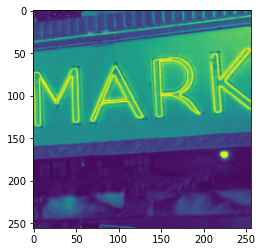

In [6]:
plt.imshow( batch["image1"][0][0] )

In [7]:
x1 = batch['image1']
x2 = batch["image2"]
feature_encoder = FeatureEncoder()
attention_model = AttentionLayer(feature_encoder)

with torch.no_grad():
    x1_encoded = attention_model.concat_layers(attention_model.feature_encoder.forward(x1)) #bx48x32x32
    x2_encoded = attention_model.concat_layers(attention_model.feature_encoder.forward(x2))


y1 = attention_model.forward(x1_encoded) #bx1x32x32
y2 = attention_model.forward(x2_encoded)


loss = attention_model.loss(x1_encoded, x2_encoded, y1, y2, batch)
print(loss)

tensor([1.9984], grad_fn=<DivBackward0>)
